In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# **Value iteration**

In [ ]:
def value_iteration_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s,h, V, rewards):
        """
        Calculate the value for all action in a given state.
        """
        A = np.zeros(with_dummy_states) # can bet 0 to 100
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # This is the core of the Bellman equation: The expected value of your action is 
                # the sum of immediate rewards and the value of the next state.
                A[a] = p_h * (rewards[s+a] + V[s+a,h+1]) + (1-p_h) * (rewards[s-a] + V[s-a,h+1])
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                A[a] = p_h * rewards[s+a] + (1-p_h) * rewards[s-a]
        
        return A
    
    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        print(h)
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value        
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

In [ ]:
horizon_l = 100
max_states_plus_1 = 50
nonrobust_opt_policy, nonrobust_opt_v = value_iteration_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l)

print("Optimized Policy:")
print(nonrobust_opt_policy[:,horizon_l-2])
print(nonrobust_opt_policy[max_states_plus_1,horizon_l-2])
print("Optimized Value Function:")
print(nonrobust_opt_v[:,0])

# **generate samples for P_hat**

In [ ]:
## generating samples for estimating P_h

## version 1
# def empirical_est(p_h,n=20, horizon_l = 100):
    
#     ns = [0, 1] # == s+a, s-a states
#     est_p = []
#     for h in range(horizon_l):
#         data = np.random.choice(ns, n, p = [p_h, 1-p_h])
    
#         est_ph = [len(np.where(data == 0)[0])*1.0/n,
#                  len(np.where(data == 1)[0])*1.0/n,]
#         est_p.append(est_ph)
#     print(np.shape(est_ph))
#     print(np.shape(est_p))
#     print(est_p[1][0])
#     print(est_p[1][1])
#     return est_p

## version 2: only generate one P_h,s,a
def empirical_est(p_h,n=20):
    
    ns = [0, 1] # == s+a, s-a states
    data = np.random.choice(ns, n, p = [p_h, 1-p_h])
    
    est_ph = [len(np.where(data == 0)[0])*1.0/n,
                 len(np.where(data == 1)[0])*1.0/n,]
   
    return est_ph

In [ ]:
empirical_est(p_h=0.6,n=100)

# Value iteration with pessimism

In [ ]:
def value_iteration_lcb_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100, num_samp=100):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def bonus(h, s, a, p, n_sa, z):
        
        cb = 0.005
        b1 = horizon_l - h
        
        var_V = p*z[0]**2 + (1-p)*z[1]**2 - (p*z[0] + (1-p)*z[1])**2
        if abs(var_V<1e-6):
            var_V=0
    
        b2 = cb* horizon_l/n_sa + cb*math.sqrt(var_V/n_sa)
        
        return np.min([b1,b2])

    def one_step_lookahead(s,h, V, rewards):
        """
        Calculate the value for all action in a given state.
        """
        A = np.zeros(with_dummy_states) # can bet 0 to 100
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # This is the core of the Bellman equation: The expected value of your action is 
                # the sum of immediate rewards and the value of the next state.
                est_p = empirical_est(p_h,n= num_samp)
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                A[a] = est_p[0] * z[0] + (1- est_p[0]) * z[1]
                b = bonus(h, s, a, est_p[0], num_samp, z)
                A[a] = np.max([A[a] - b,0])
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                est_p = empirical_est(p_h,n= num_samp)
                z = [rewards[s+a], rewards[s-a]]
                A[a] = est_p[0] * z[0] + (1-est_p[0]) * z[1]
                b = bonus(h, s, a, est_p[0], num_samp, z)
                A[a] = np.max([A[a] - b,0])
        return A
    
    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
#         print(h)
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value        
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

In [ ]:
num_samp = 300
nonrobust_lcb_opt_policy, nonrobust_lcb_opt_v = value_iteration_lcb_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l, num_samp = num_samp)

print("Optimized Policy:")
print(nonrobust_lcb_opt_policy[:,horizon_l-2])
print(nonrobust_lcb_opt_policy[max_states_plus_1,horizon_l-2])
print("Optimized Value Function:")
print(nonrobust_lcb_opt_v[:,0])

# **Get KL robustness results**

In [33]:
# KL ambiguity
from numpy import ma
from scipy.optimize import minimize
from cvxopt import solvers, matrix, spdiag, log
import cvxpy as cp

In [ ]:
def get_KL_lambda(v, q, c_r):
    """
    o = worstcase_l1(v,q,t)

    Computes the solution of:
    min_p   lambda log(ph e^{-V[s+a]/lambda} + (1-ph)e^{-V[s-a]/lambda}) + lambda c_r
    s.t.    lambda >=0
    via it's Dual formulation

    where o is the objective value

    Notes
    -----

    """

    if c_r == 0 or c_r + np.log(1-q)>=0 or np.max(v)<1e-10:
#         print([q*v[0] + (1-q)*v[1], 0.0])
        return q*v[0] + (1-q)*v[1], 0.0
    if c_r < 0:
        raise ValueError('Bound t must be greater than 0.')
        
    if np.abs(v[0]-v[1])<1e-10:  # in this case, no mater P_hat and P diff, does not influence the value
        return q*v[0] + (1-q)*v[1], 0.0
    
#     print('now the radius c_r is ' + str(c_r + np.log(1-q)))
    
    
    ## use scipy: may have bug
    fun = lambda x: x*np.log(q*np.exp(-v[0]/x) + (1-q)*np.exp(-v[1]/x)) + x*c_r
#     cons = ({'type': 'ineq', 'fun': lambda x:  x}
    bounds = [(0, None)]
    x0 = np.min([np.max(v)/10/c_r, 0.1])
#     print(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bounds,tol=1e-3) #, options = {'disp': True})
    
    # if the result is near zero, then output it
    if np.abs(res.fun)<1e-10:
        func_value = 0
    else:
        func_value = -res.fun
    if np.abs(res.x)<1e-10:
        kl_lam = 0.0
    else:
        kl_lam = res.x[0]
    
    def self_cal_lam():
        # do my own work
        def cal_gradient(x):
            now_deno = q*np.exp(-v[0]/x) + (1-q)*np.exp(-v[1]/x)
            return -c_r -np.log(now_deno) - (v[0]/x*q*np.exp(-v[0]/x)+ v[1]/x*(1-q)*np.exp(-v[1]/x))/now_deno
        
        def cal_func():
            kl = p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
            pv_test = p*v[0] + (1-p)*v[1]
            return kl, pv_test
        
        pl = 0
        pr=np.max(v)/c_r
        t = 1
        while True:
            lam = pl+ (pr-pl)/2
#             print(lam)
#             print(lam*np.log(q*np.exp(-v[0]/lam) + (1-q)*np.exp(-v[1]/lam)) + lam*c_r)
            if cal_gradient(lam)<0: # lambda > lambda^star
                pr = lam
            else:
                pl= lam
            
            if abs(cal_gradient(lam))<1e-6 or t>100: # we find the good lambda
                func = -(lam*np.log(q*np.exp(-v[0]/lam) + (1-q)*np.exp(-v[1]/lam)) + lam*c_r)
                if func>10:
                    print(lam)
                    ql = 0
                    qr = q
                    t_func = 1
                    while True:
                        q_min = ql+ (qr-ql)/2
                        print('now q is' + str(q))
                        if q_min*np.log(q_min/q) + (1-q_min)*np.log((1-q_min)/(1-q)) < c_r: # now the  q_min is too big
                            qr = q_min
                        else:
                            ql = q_min
                        
                        if abs(q_min*np.log(q_min/q) + (1-q_min)*np.log((1-q_min)/(1-q)) - c_r)<1e-6 or t_func>100:
                            return q_min*v[0] + (1-q_min)*v[1], lam
                        
                        t_func +=1
                        
#                 print(func, lam)                    
                return func, lam
            t +=1
            
                
    
    if np.isnan(res.fun) or np.isnan(res.x) or abs(res.fun)>10:
#         print(v)
        func_value, kl_lam = self_cal_lam()
        
    
#         raise ValueError('There are nan.')

    
#     ## use cvxpy 
#     x = cp.Variable(nonneg=True)
# #       x.value = np.min([np.max(v)/10/c_r, 0.1])
    
#     objective = cp.Minimize(x*cp.log(q*cp.exp(-v[0]/x) + (1-q)*cp.exp(-v[1]/x)) + x*c_r)
#     constraints = [0<=x, x==y]
#     prob = cp.Problem(objective, constraints)
#     # The optimal objective value is returned by `prob.solve()`.
#     result = prob.solve()
#     # The optimal value for x is stored in `x.value`.
    
#     func_value = -result
#     kl_lam = x.value

    
#     ## use cvxopt
#     def F(x=None, z=None):
#         if x is None: return 0.0, matrix(0.0, (1,1))
#         if x <= 0.0: return None
#         f = x*np.log(q*np.exp(-v[0]/x) + (1-q)*np.exp(-v[1]/x)) + x*c_r
#         now_deno = q*np.exp(-v[0]/x) + (1-q)*np.exp(-v[1]/x)
#         Df = c_r + np.log(now_deno) + (v[0]/x*q*np.exp(-v[0]/x)+ v[1]/x*(1-q)*np.exp(-v[1]/x))/now_deno
#         Df = matrix(Df, (1,1))
#         if z is None: return f, Df
#         return f, Df
#     G = matrix(-1.0, (1,1))
#     h = matrix(0.0, (1,1))
#     return solvers.cp(F,G,h)['x']
        
   
        
    

    
#     print('value '+str(func_value) + ' '+ str(kl_lam))
    return func_value, kl_lam


# this function is to test whether "get_KL_lambda" is right
def cal_kl(v,p,q):
    kl = p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
    pv_test = p*v[0] + (1-p)*v[1]
    return kl, pv_test

## test the KL_lambda result
get_KL_lambda([0.08,0.04],0.3, 0.1)
cal_kl([0.08,0.04], 0.37794, 0.3)

# **Robust VI algorithm**

In [ ]:
def robust_vi_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100, c_r=0.2, uncer='kl',num_samp=200):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def one_step_lookahead(s,h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    if np.isnan(A[a]) or np.isnan(lam):
                        raise ValueError('nan in value.')
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    est_p = empirical_est(p_h,n= num_samp)
                    A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                    A[a] = np.max([A[a],0])
                    # to be added a bonus term
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    est_p = empirical_est(p_h,n= num_samp)
                    A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                    A[a] = np.max([A[a],0])
                    # to be added a bonus term
        return A
    

    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
        print(h)
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards, c_r)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break
            
    # show the difference between the estimation of the optimal value and the optimal value
    if uncer=='klhat':
        P_robust_value=robust_opt_v_kl[:,0]
        P_hat_robust_value = V[:,0]
        v_k_robopt_diff = np.abs(P_robust_value - P_hat_robust_value)

#         ### LEARNING CURVE save data
#         np.savetxt('gambler_l1_cr_0.2_learning.csv', (range(1,itera), v_k_robopt_diff),\
#                                        delimiter=',')
        #### Temporary plot
#         plt.figure()
        plt.plot(range(with_dummy_states),v_k_robopt_diff)
        plt.ylabel(r'$||V^*(s) - V(s)||$')
        plt.xlabel('index of states')
    

    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards, c_r)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

In [ ]:
# horizon_l = 50
# max_states_plus_1 = 5
num_samp = 100
robust_opt_policy_kl, robust_opt_v_kl= robust_vi_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl', num_samp = num_samp)

print("Optimized Policy:")
print(robust_opt_policy_kl)

print("Optimized Value Function:")
print(robust_opt_v_kl[:,0])
print(robust_opt_v_kl[:,1])

In [ ]:
robust_hat_policy_kl, robust_hat_v_kl= robust_vi_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat', num_samp = num_samp)

print("Optimized Policy:")
print(robust_hat_policy_kl)

print("Optimized Value Function:")
print(robust_opt_v_kl[:,0])
print(robust_opt_v_kl[:,1])

# Robust VI-LCB algorithm

In [ ]:
import math
def robust_vi_lcb_for_gamblers(p_h, max_states_plus_1 = 100, horizon_l = 100, c_r=0.2, uncer='kl',num_samp=40):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    def bonus(h, s, a, lam_now, p, n_sa):
        
        
        b1 = horizon_l - h
        # the bonus of exponential e^{H/a}
        cb = 0.5
        if math.log(cb*lam_now*math.sqrt(1/n_sa)) + (horizon_l- h)/lam_now < log(b1):
            b2 = cb*lam_now * math.exp((horizon_l-h)/lam_now)*math.sqrt(1/n_sa)
        else:
#             print(math.log(cb*lam_now*math.sqrt(1/n_sa)) + (horizon_l-h)/lam_now)
            b2 = b1
        
        # the bonus of P-min
        if p == 0 or 1-p ==0:
            b3 = cb*lam_now*math.sqrt(1/n_sa)
        else:
            b3 = cb*lam_now*math.sqrt(1/n_sa/np.min([p,1-p]))
        
#         if np.min([b1,b2,b3]) != b1:
#             print('use it')
#         return np.min([b1, b2,b3])
        return np.min([b1, b3])

    def one_step_lookahead(s,h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    if A[a]>horizon_l:
                        raise ValueError('value too big.')
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    n_sa = num_samp
                    if n_sa >0:
                        est_p = empirical_est(p_h,n= n_sa)
                        A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                        
                        # add bonus
                        if lam >0:
                            b_sa = bonus(h, s, a, lam, est_p[0], n_sa)
                            A[a] = A[a] - b_sa
                    else:
                        A[a] = 0
                    A[a] = np.max([A[a],0])
                    
                    # to be added a bonus term
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    n_sa = num_samp
                    if n_sa >0:
                        est_p = empirical_est(p_h,n= num_samp)
                        A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                        # add bonus
                        if lam >0:
                            b_sa = bonus(h, s, a, lam, est_p[0], n_sa)
                            A[a] = A[a] - b_sa
                    else:
                        A[a] = 0                      
                    A[a] = np.max([A[a],0])
                    # to be added a bonus term
        return A
    
    

    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
#         print(h)
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h, V, rewards, c_r)
            best_action_value = np.max(A)
            # Update the value function.
            V[s,h] = best_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break
            
    # show the difference between the estimation of the optimal value and the optimal value
    if uncer=='klhat':
        P_robust_value=robust_opt_v_kl[:,0]
        P_hat_robust_value = V[:,0]
        v_k_robopt_diff = np.abs(P_robust_value - P_hat_robust_value)

#         ### LEARNING CURVE save data
#         np.savetxt('gambler_l1_cr_0.2_learning.csv', (range(1,itera), v_k_robopt_diff),\
#                                        delimiter=',')
        #### Temporary plot
#         plt.figure()
        plt.plot(range(with_dummy_states),v_k_robopt_diff)
        plt.ylabel(r'$||V^*(s) - V(s)||$')
        plt.xlabel('index of states')
    
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros((with_dummy_states, horizon_l))
    for h in range(horizon_l-1,-1,-1):
        for s in range(1, max_states_plus_1): # money is [1,100]
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, h, V, rewards, c_r)
            best_action = np.argmax(A)
            # Always take the best action
            policy[s,h] = best_action
    
    return policy, V

In [ ]:
lcb_robust_hat_policy_kl, lcb_robust_hat_v_kl= robust_vi_lcb_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = num_samp)

print("Optimized Policy:")
print(robust_hat_policy_kl)

print("Optimized Value Function:")
print(robust_opt_v_kl[:,0])
print(robust_opt_v_kl[:,1])

# get the value of a policy pi

In [ ]:
def get_V_p_real(pi, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = num_samp,alg = 'lcb-vi', show = 'True'):
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros((with_dummy_states, horizon_l))
    
    
    def one_step_lookahead(s,h, V, rewards, c_r):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        
        
        if h<horizon_l-1: # when the time < horizon length
            for a in stakes:
                # rewards[s+a], rewards[s-a] are immediate rewards.
                # V[s+a], V[s-a] are values of the next states.
                # Robust Bellman equation:
                z = [rewards[s+a] + V[s+a,h+1], rewards[s-a] + V[s-a,h+1]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    if np.isnan(A[a]) or np.isnan(lam):
                        raise ValueError('nan in value.')
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    est_p = empirical_est(p_h,n= num_samp)
                    A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                    A[a] = np.max([A[a],0])
                    # to be added a bonus term
                    
        else: # in the final step of the horizon, V[H] = 0
            for a in stakes:
                z = [rewards[s+a], rewards[s-a]]
                if uncer=='kl':
                    A[a],lam = get_KL_lambda(np.array(z), p_h, c_r)
                    A[a] = np.max([A[a],0])
                elif uncer=='klhat':
                    est_p = empirical_est(p_h,n= num_samp)
                    A[a],lam = get_KL_lambda(np.array(z), est_p[0], c_r)
                    A[a] = np.max([A[a],0])
                    # to be added a bonus term
        return A
    
    # get the value functions V_h
    for h in range(horizon_l-1,-1,-1):
#         print(h)
        # Update each state...
        for s in range(1, max_states_plus_1): # s = 0 means 0
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, h,V, rewards, c_r)
            policy_action_value = A[int(pi[s][h])]
            # Update the value function.
            V[s,h] = policy_action_value
            if np.isnan(V[s,h]):
                raise ValueError('nan in value.')
                break
    
    # show the difference between the estimation of the optimal value and the optimal value
    if uncer=='kl':
        P_robust_value=robust_opt_v_kl[:,0]
        P_hat_robust_value = V[:,0]
        v_k_robopt_diff = P_robust_value - P_hat_robust_value

#         ### LEARNING CURVE save data
#         np.savetxt('gambler_l1_cr_0.2_learning.csv', (range(1,itera), v_k_robopt_diff),\
#                                        delimiter=',')
        #### Temporary plot
#         plt.figure()
        plt.plot(range(with_dummy_states),v_k_robopt_diff)
        plt.ylabel(r'$V^\star(s) - V^{\pi}(s)$')
        plt.xlabel('index of states')
        if alg == 'lcb-vi':
            plt.legend('Ours')
        elif alg =='vi':
            plt.legend('Robust vi')
        
    return V, v_k_robopt_diff

In [ ]:
# get the real value of the DR-VI-LCB algorithm
fig = plt.figure()
lcb_pi_V_p_real, lcb_pi_V_p_real_diff = get_V_p_real(lcb_robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'lcb-vi',show = 'True')
print("LCB Policy Value Function:")
print(lcb_pi_V_p_real[:,0])
print(lcb_pi_V_p_real[:,1])

# get the real value of other VI-LCB algorithm
VI_pi_V_p_real, VI_pi_V_p_real_diff = get_V_p_real(robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'vi',show = 'True')
print("LCB Policy Value Function:")
print(VI_pi_V_p_real[:,0])
print(VI_pi_V_p_real[:,1])

print(lcb_pi_V_p_real_diff)
print(VI_pi_V_p_real_diff)


fig.savefig('compare-LCB-or-VI.png',bbox_inches='tight', dpi=600)



# Figure of performance diff w.r.t state

In [ ]:
s_range = range(10)
num_samp = 100
diff_lcbvi_seeds_s = np.zeros((len(s_range),max_states_plus_1+1))
diff_vi_seeds_s = np.zeros((len(s_range),max_states_plus_1+1))
for s in s_range:
    print("seed - ", s)
    diff_lcbvi_values = []
    diff_vi_values = []
    np.random.seed(s)
    ## calculate the VI-LCB policy
    lcb_robust_hat_policy_kl, lcb_robust_hat_v_kl= robust_vi_lcb_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = num_samp)
    # get the real value of the DR-VI-LCB algorithm
    lcb_pi_V_p_real, lcb_pi_V_p_real_diff = get_V_p_real(lcb_robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'lcb-vi', show = False)
    diff_lcbvi_values = lcb_pi_V_p_real_diff
        
    ## calculate the VI-LCB policy
    vi_robust_hat_policy_kl, vi_robust_hat_v_kl= robust_vi_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = num_samp)
    # get the real value of the DR-VI-LCB algorithm
    vi_pi_V_p_real, vi_pi_V_p_real_diff = get_V_p_real(vi_robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'vi', show = False)
    diff_vi_values = vi_pi_V_p_real_diff
#         pol.append(temp_pol)
    diff_lcbvi_seeds_s[s,:] = diff_lcbvi_values
    diff_vi_seeds_s[s,:] = diff_vi_values



[0.         0.00043783 0.0010217  0.00120107 0.00182476 0.00163695
 0.00280363 0.00429921 0.0054624  0.00553049 0.00512762 0.00615677
 0.00723211 0.0154233  0.01075963 0.0102894  0.01125278 0.00783923
 0.00903427 0.00826643 0.00805904 0.01259335 0.01107007 0.01055252
 0.01713483 0.03031626 0.02492837 0.02142944 0.01932921 0.01961234
 0.02137685 0.01739178 0.01483906 0.01553401 0.02007563 0.02003643
 0.01550089 0.01513693 0.0241137  0.02544927 0.02744432 0.01991838
 0.01816797 0.0201172  0.02079209 0.01990348 0.01188737 0.00971741
 0.01002415 0.00462137 0.        ]
[0.         0.00018341 0.00075335 0.00109003 0.002387   0.00176133
 0.00375664 0.00323275 0.00552308 0.01195415 0.01170163 0.00612439
 0.01200695 0.00737874 0.0090279  0.01565178 0.02307904 0.01548196
 0.01984504 0.02323283 0.0248647  0.02150456 0.02296386 0.01314888
 0.01861616 0.01724786 0.03002236 0.02456437 0.03545037 0.04832682
 0.0241291  0.02678027 0.04963436 0.03844667 0.05159201 0.03050351
 0.02999065 0.03800798 0.04

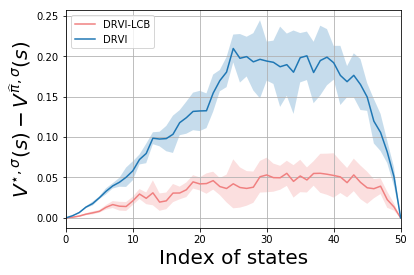

In [28]:
#---------- figure of robust VI vs robust VI-LCB w.r.t N with p_h = 0.6
colorbar = ['C2', 'lightcoral', 'C0', 'mediumpurple']
fig = plt.figure()
# plot VI-LCB
mean_lcbvi_vals = np.mean(diff_lcbvi_seeds_s,axis=0)
std_lcbvi_vals = np.std(diff_lcbvi_seeds_s,axis=0)
print(std_lcbvi_vals)
plt.plot(range(max_states_plus_1+1),mean_lcbvi_vals, color = colorbar[1], label='DRVI-LCB')
plt.fill_between(range(max_states_plus_1+1), mean_lcbvi_vals - std_lcbvi_vals, mean_lcbvi_vals + std_lcbvi_vals, facecolor = colorbar[1], alpha = 0.25)

# plot LCB
mean_vi_vals = np.mean(diff_vi_seeds_s,axis=0)
std_vi_vals = np.std(diff_vi_seeds_s,axis=0)
print(std_vi_vals)
plt.plot(range(max_states_plus_1+1),mean_vi_vals, color = colorbar[2], label='DRVI')
plt.fill_between(range(max_states_plus_1+1), mean_vi_vals - std_vi_vals, mean_vi_vals + std_vi_vals, facecolor = colorbar[2], alpha = 0.25)

plt.xlabel("Index of states",fontsize=20)
plt.ylabel(r'$V^{\star,\sigma}(s) - V^{\widehat{\pi},\sigma}(s)$',fontsize=20)
plt.legend(loc = 'upper left')
plt.xlim([0,50])
plt.grid()
plt.show()
fig.savefig('test_lcb_vi_state.pdf',format='pdf', bbox_inches='tight')

# Uncomment this if you want to save data
np.savetxt('gambler_kl_c_r_0.1_s.csv', (mean_vi_vals, std_vi_vals, mean_lcbvi_vals,std_lcbvi_vals),\
                                   delimiter=',')

# figure of performance diff w.r.t N

In [ ]:
rho = np.random.uniform(0,1,max_states_plus_1+1)
rho = rho/np.sum(rho)
# n_range = [100, 500, 3000, 5000, 7000]
n_range = [100, 300, 1000, 3000, 5000]
s_range = range(10)
diff_lcbvi_seeds = np.zeros((len(s_range),len(n_range)))
diff_vi_seeds = np.zeros((len(s_range),len(n_range)))
for s in s_range:
    print("seed - ", s)
    diff_lcbvi_values = []
    diff_vi_values = []
#     pol = []
    for n in n_range:
        np.random.seed(s+n)
        ## calculate the VI-LCB policy
        lcb_robust_hat_policy_kl, lcb_robust_hat_v_kl= robust_vi_lcb_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = n)
        # get the real value of the DR-VI-LCB algorithm
        lcb_pi_V_p_real, lcb_pi_V_p_real_diff = get_V_p_real(lcb_robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'lcb-vi', show = False)
        diff_lcbvi_values.append(np.dot(rho,lcb_pi_V_p_real_diff))
        
        ## calculate the VI-LCB policy
        vi_robust_hat_policy_kl, vi_robust_hat_v_kl= robust_vi_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = n)
        # get the real value of the DR-VI-LCB algorithm
        vi_pi_V_p_real, vi_pi_V_p_real_diff = get_V_p_real(vi_robust_hat_policy_kl, p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='kl',num_samp = num_samp, alg = 'vi', show = False)
        diff_vi_values.append(np.dot(rho,vi_pi_V_p_real_diff))
#         pol.append(temp_pol)
    diff_lcbvi_seeds[s,:] = diff_lcbvi_values
    diff_vi_seeds[s,:] = diff_vi_values

# plot lcb-vi
plt.figure()
plt.plot(n_range,diff_lcbvi_values)
plt.xlabel("N")
plt.ylabel("value diff")

fig = plt.figure()
plt.plot(n_range,np.mean(diff_lcbvi_seeds,axis=0))
plt.xlabel("N")
plt.ylabel(r'$V^\star(\rho) - V^{\widehat{\pi}}(\rho)$')

fig.savefig('test_lcbvi_N.png')

# plot vi
plt.figure()
plt.plot(n_range,diff_vi_values)
plt.xlabel("N")
plt.ylabel("value diff")

fig = plt.figure()
plt.plot(n_range,np.mean(diff_vi_seeds,axis=0))
plt.xlabel("N")
plt.ylabel(r'$V^\star(\rho) - V^{\widehat{\pi}}(\rho)$')

fig.savefig('test_vi_N.pdf',format='pdf', bbox_inches='tight')

[0.00385396 0.00317502 0.00298042 0.00077067 0.00065203]
[0.018733   0.01183882 0.0020437  0.00080014 0.00039573]


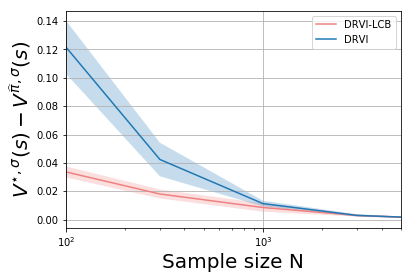

In [30]:
#---------- figure of robust VI vs robust VI-LCB w.r.t N with p_h = 0.6
colorbar = ['C2', 'lightcoral', 'C0', 'mediumpurple']
fig = plt.figure()

# plot VI-LCB
mean_lcbvi_vals = np.mean(diff_lcbvi_seeds,axis=0)
std_lcbvi_vals = np.std(diff_lcbvi_seeds,axis=0)
print(std_lcbvi_vals)
plt.plot(n_range,mean_lcbvi_vals, color = colorbar[1], label='DRVI-LCB')
plt.fill_between(n_range, mean_lcbvi_vals - std_lcbvi_vals, mean_lcbvi_vals + std_lcbvi_vals, facecolor = colorbar[1], alpha = 0.25)


# plot LCB
mean_vi_vals = np.mean(diff_vi_seeds,axis=0)
std_vi_vals = np.std(diff_vi_seeds,axis=0)
print(std_vi_vals)
plt.plot(n_range,mean_vi_vals, color = colorbar[2], label='DRVI')
plt.fill_between(n_range, mean_vi_vals - std_vi_vals, mean_vi_vals + std_vi_vals, facecolor = colorbar[2], alpha = 0.25)




plt.xlabel("Sample size N",fontsize=20)
plt.ylabel(r'$V^{\star,\sigma}(s) - V^{\widehat{\pi},\sigma}(s)$',fontsize=20)
plt.legend(loc = 'upper right')
plt.xlim([100,5000])
plt.grid()
plt.xscale('log')
plt.show()
fig.savefig('test_lcb_vi_N.pdf',format='pdf', bbox_inches='tight')

# Uncomment this if you want to save data
np.savetxt('gambler_kl_c_r_0.1_N.csv', (n_range, mean_vi_vals, std_vi_vals, mean_lcbvi_vals,std_lcbvi_vals),\
                                   delimiter=',')

# Figure of comparison with non-robust policy

In [31]:
def gamblers_step(s, a, p, max_states_plus_1):
    if np.random.binomial(1, p, 1):
        ns = s + a
    else:
        ns = s - a
        
    if ns >= max_states_plus_1:
        return ns, 1
    else:
        return ns, 0

def run_policy(p, policy, max_states_plus_1 = 100, max_steps = horizon_l):
    current_state = np.random.randint(1,max_states_plus_1-1)
    
    for h in range(max_steps):
        nextstate, reward = gamblers_step(current_state, policy[int(current_state),h], p, max_states_plus_1)
#         print(nextstate, policy[int(current_state)])=
        
        if nextstate == 0:
            return 0, h
        
        if reward == 1:
            return reward, h

        current_state=nextstate
    return 0, h

50 100
seed -  0
seed -  1
seed -  2
seed -  3
seed -  4
seed -  5
seed -  6
seed -  7
seed -  8
seed -  9


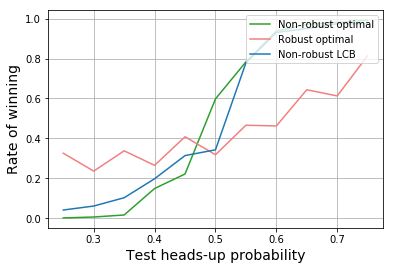

In [34]:
# test the robust optimal policy
print(max_states_plus_1,horizon_l)
# head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.46, 0.55, 0.6, 0.65, 0.7]
# head_p = 0.5+0.01*np.arange(10)
head_p = 0.25 + 0.05*np.arange(11)
n_runs = 3000
s_range = range(10)

win_ratio_seeds = np.zeros((len(s_range),len(head_p), 3))

for s in s_range:
    print("seed - ", s)
    policies = []
    # non-robust opt
    policies.append( nonrobust_opt_policy )
    # robust opt kl
    policies.append( robust_opt_policy_kl )
    num_samp = 1000
    nonrobust_lcb_opt_policy, nonrobust_lcb_opt_v = value_iteration_lcb_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l,num_samp=num_samp)
    policies.append( nonrobust_lcb_opt_policy )
    win_percent_data = [] 
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = max_states_plus_1, max_steps = horizon_l)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds[s,jj,:] = win_percent

    #---------- figure of robust VI vs robust VI-LCB w.r.t N with p_h = 0.6
colorbar = ['C2', 'lightcoral', 'C0', 'mediumpurple']
fig = plt.figure()
mean_vals = np.mean(win_ratio_seeds,axis=0)
for i in range(len(policies)):
    # plot non-robust optimal
    if i==0:
        now_label = 'Non-robust optimal'
    elif i ==1:
        now_label = 'Robust optimal'
    elif i ==2:
        now_label = 'Non-robust LCB'
    plt.plot(head_p, mean_vals[:,i], color = colorbar[i], label= now_label)
#     plt.fill_between(head_p, mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i], color = colorbar[i], alpha = 0.5)


plt.xlabel("Test heads-up probability",fontsize=14)
plt.ylabel("Rate of winning",fontsize=14)
plt.legend(loc = 'upper right')
plt.grid()
# plt.xscale('log')
plt.show()
fig.savefig('test_winning.png',bbox_inches='tight', dpi=600)

In [35]:
# # special session for adding nonrobust-lcb result:
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7]
head_p = 0.25 + 0.05*np.arange(11)
n_runs = 3000
s_range = range(10)


win_ratio_seeds_new = np.zeros((len(s_range),len(head_p), 1))
for s in s_range:
    print("seed - ", s)
    policies = []
    nonrobust_lcb_opt_policy, nonrobust_lcb_opt_v = value_iteration_lcb_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l)
    policies.append( nonrobust_lcb_opt_policy )
    win_percent_data = []
    
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = max_states_plus_1, max_steps = horizon_l)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds_new[s,jj,:] = win_percent

seed -  0
seed -  1


KeyboardInterrupt: 

In [ ]:
# test all the policies
# do the heads up test
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7]
head_p = 0.25 + 0.05*np.arange(11)
n_runs = 3000
s_range = range(10)

policies_num = 5
win_ratio_seeds = np.zeros((len(s_range),len(head_p), policies_num))

for s in s_range:
    print("seed - ", s)
    policies = []
    # non-robust opt
    policies.append( nonrobust_opt_policy )
    # robust opt kl
    policies.append( robust_opt_policy_kl )
    # robust VI policies for N samples in n_range
    # get the robust VI and robust VI-LCB policy
    num_samp = 1000
    robust_hat_policy_kl, robust_hat_v_kl= robust_vi_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat', num_samp = num_samp)
    lcb_robust_hat_policy_kl, lcb_robust_hat_v_kl= robust_vi_lcb_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = 0.1, uncer='klhat',num_samp = num_samp)
    nonrobust_lcb_opt_policy, nonrobust_lcb_opt_v = value_iteration_lcb_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l,num_samp = num_samp)
    policies.append( nonrobust_lcb_opt_policy )
    policies.append( robust_hat_policy_kl )
    # robust LCB-VI policies for N samples in n_range
    policies.append( lcb_robust_hat_policy_kl )
#     for j, _ in enumerate(n_range):
#         policies.append( pol_seed[s][j] )
    win_percent_data = []
    
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = max_states_plus_1, max_steps = horizon_l)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds[s,jj,:] = win_percent

In [ ]:
mean_vals = np.mean(win_ratio_seeds,axis=0)
std_vals = np.std(win_ratio_seeds,axis=0)


#---------- figure of robust VI vs robust VI-LCB w.r.t N with p_h = 0.6
colorbar = ['C7','C0','C2', 'mediumpurple','lightcoral']
fig = plt.figure()

for i in range(len(policies)):
    # plot non-robust optimal
    if i==0:
        now_label = 'Non-robust optimal'
    elif i ==1:
        now_label = 'Robust optimal'
    elif i ==2:
        now_label = 'Non-robust VI-LCB'    
    elif i == 3:
        now_label = 'DRVI'
        
    else:
        now_label = 'DRVI-LCB'
    if i==3:
        continue
    else:
        plt.plot(head_p, mean_vals[:,i], color = colorbar[i], label= now_label,linewidth=2.5)
#     plt.fill_between(head_p, mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i], color = colorbar[i], alpha = 0.5)

# # special session for adding nonrobust-lcb result:
# mean_vals_nonrobust_lcb = np.mean(win_ratio_seeds_new,axis=0)
# std_vals_nonrobust_lcb = np.std(win_ratio_seeds_new,axis=0)
# plt.plot(head_p, mean_vals_nonrobust_lcb, color = colorbar[2], label= 'Non-robust VI-LCB',linewidth=2.5)

plt.xlabel("Test heads-up probability",fontsize=14)
plt.ylabel("Ratio of winning",fontsize=14)
plt.legend(loc = 'upper left')
plt.grid()
# plt.xscale('log')
plt.show()
fig.savefig('test_winning.pdf',bbox_inches='tight', format ='pdf')



# Note-to-self: High time I learn using panda!
head_p_with_mean_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
head_p_with_mean_vals[:,0:mean_vals.shape[1]] = mean_vals
head_p_with_mean_vals[:,-1] = head_p

head_p_with_std_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
head_p_with_std_vals[:,0:mean_vals.shape[1]] = std_vals
head_p_with_std_vals[:,-1] = head_p
print(head_p_with_mean_vals)
print(head_p_with_std_vals)


# Uncomment this if you want to save data
# np.savetxt('gambler_l1_c_r_0.2_test_performance_2.csv', (head_p_with_mean_vals.reshape(-1), head_p_with_std_vals.reshape(-1)),\
#                                    delimiter=',')

# test robust VI-LCB with different sigma

seed -  0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.7/site-packages/scipy/optimize/slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered

0.0003838392787309004
0.00045422847585556403
0.0003838392787309004
seed -  1
0.00038287685221687713
0.00038287685221687713
seed -  2
seed -  3
0.00010577828428888497
seed -  4
seed -  5
seed -  6
0.0003853519663723421
0.00040454758364885006
0.0003853519663723421
0.00040454758364885006
seed -  7
0.0003853519663723421
0.00040454758364885006
0.0003853519663723421
0.00040454758364885006
seed -  8
seed -  9
0.0001068933043854748
0.0001068933043854748
0.0004936316807717224
seed -  10
seed -  11
0.0001068933043854748
0.0001068933043854748
0.0004936316807717224
seed -  12
seed -  13
0.0003897256617544767
0.0003897256617544767
seed -  14
seed -  15
seed -  16
0.0009648960512253712
seed -  17
0.00047545210574721113
0.00047545210574721113
seed -  18
seed -  19
0.00047545210574721113
0.00047545210574721113


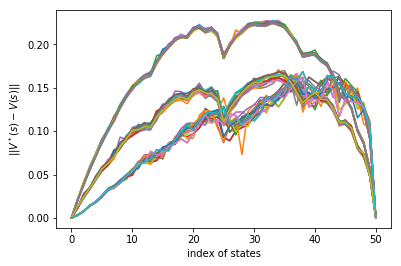

In [42]:
# test robust VI-LCB with different sigma
# do the heads up test
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7]
head_p = 0.25 + 0.05*np.arange(11)
n_runs = 3000
s_range = range(20)
sigma = [0.001, 0.01,0.2]
policies_num = 4
win_ratio_seeds = np.zeros((len(s_range),len(head_p), policies_num))

for s in s_range:
    print("seed - ", s)
    policies = []
    # robust VI policies for N samples in n_range
    # get the robust VI and robust VI-LCB policy
    np.random.seed(np.random.randint(s+10))
    num_samp = 1000
    # nonrobust VI-LCB
#     nonrobust_lcb_opt_policy, nonrobust_lcb_opt_v = value_iteration_lcb_for_gamblers(p_h = 0.6, max_states_plus_1= max_states_plus_1, horizon_l = horizon_l,num_samp = num_samp)
#     policies.append( nonrobust_lcb_opt_policy )
    
    # non-robust opt
    policies.append( nonrobust_opt_policy )
    # robust LCB-VI policies for N samples in n_range
    for sig,_ in enumerate(sigma):
        lcb_robust_hat_policy_kl, lcb_robust_hat_v_kl= robust_vi_lcb_for_gamblers(p_h = 0.6, max_states_plus_1 = max_states_plus_1, horizon_l = horizon_l, c_r = sigma[sig], uncer='klhat',num_samp = num_samp)
        policies.append( lcb_robust_hat_policy_kl )
#     for j, _ in enumerate(n_range):
#         policies.append( pol_seed[s][j] )
    win_percent_data = []
    
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = max_states_plus_1, max_steps = horizon_l)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds[s,jj,:] = win_percent

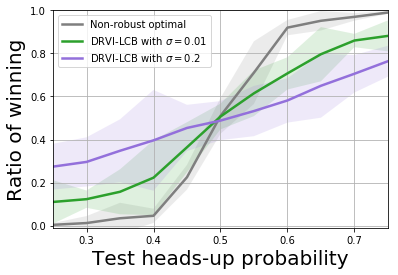

In [43]:
mean_vals = np.mean(win_ratio_seeds,axis=0)
std_vals = np.std(win_ratio_seeds,axis=0)


#---------- figure of robust VI vs robust VI-LCB w.r.t N with p_h = 0.6
# colorbar = ['C7','C0','C2', 'mediumpurple','lightcoral']
colorbar = ['C7','C0','C2', 'mediumpurple','lightcoral']
# colorbar = ['C7','C2','C1','lightcoral','C0','mediumpurple']
fig = plt.figure()

for i in range(len(policies)):
    # plot non-robust optimal
    if i==0:
#         now_label = r'$\sigma = 0$'
        now_label = 'Non-robust optimal'
    elif i ==1:
        now_label = r'DRVI-LCB with $\sigma = 0.001$'
    elif i ==2:
        now_label = r'DRVI-LCB with $\sigma = 0.01$' 
    elif i == 3:
        now_label = r'DRVI-LCB with $\sigma = 0.2$'
    elif i == 4:
        now_label = r'DRVI-LCB with $\sigma = 0.2$'    
    if i==1:
        continue
    elif i==5:
        plt.plot(head_p, mean_vals[:,i], color = colorbar[i], label= now_label,linewidth=2.5, alpha = 0.7)
        plt.fill_between(head_p, mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i], facecolor = colorbar[i], alpha = 0.15)
    else:
        plt.plot(head_p, mean_vals[:,i], color = colorbar[i], label= now_label,linewidth=2.5, alpha=1)
        plt.fill_between(head_p, mean_vals[:,i] - std_vals[:,i], mean_vals[:,i] + std_vals[:,i], facecolor = colorbar[i], alpha = 0.15)
        
# # special session for adding nonrobust-lcb result:
# mean_vals_nonrobust_lcb = np.mean(win_ratio_seeds_new,axis=0)
# std_vals_nonrobust_lcb = np.std(win_ratio_seeds_new,axis=0)
# plt.plot(head_p, mean_vals_nonrobust_lcb, color = colorbar[2], label= 'Non-robust VI-LCB',linewidth=2.5)

plt.xlabel("Test heads-up probability",fontsize=20)
plt.ylabel("Ratio of winning",fontsize=20)
plt.legend(loc = 'upper left')
plt.ylim([-0.01,1])
plt.xlim([0.25,0.75])
plt.grid()
# plt.xscale('log')
plt.show()
fig.savefig('test_winning.pdf',bbox_inches='tight', format ='pdf')

In [ ]:
print(head_p)